In [1]:
import cv2
import tf as tf
import tf2_ros as tf2
from cv_bridge import CvBridge, CvBridgeError
import rospy
import numpy as np
import ros_numpy
from sensor_msgs.msg import Image as ImageMsg, PointCloud2
from std_msgs.msg import String
bridge = CvBridge()


import matplotlib.pyplot as plt


In [29]:
rospy.init_node('notebook')

In [3]:
class RGB():
    def __init__(self):
        self._cloud_sub = rospy.Subscriber("/usb_cam/image_raw",ImageMsg, self._cloud_cb)
        self._image_data = None
    def _cloud_cb(self, msg):
        self._image_data = bridge.imgmsg_to_cv2(msg)
    def get_image(self):
        return self._image_data

In [4]:
class RGBD():
    def __init__(self):
        
        self._cloud_sub = rospy.Subscriber(
            "/hsrb/head_rgbd_sensor/depth_registered/rectified_points",

            PointCloud2, self._cloud_cb)
        
        self._points_data = None
        self._image_data = None
        

    def _cloud_cb(self, msg):
        self._points_data = ros_numpy.numpify(msg)
        self._image_data = \
                    self._points_data['rgb'].view((np.uint8, 4))[..., [2, 1, 0]]
        

    def get_image(self):
        return self._image_data

    def get_points(self):
        return self._points_data

In [5]:
rgb=RGB()


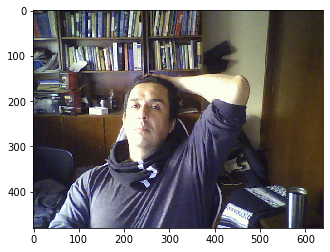

In [8]:
plt.imshow(rgb.get_image())

In [ ]:

rgbd=RGBD()

In [ ]:
#plt.imshow(rgbd.get_points()['x'],cmap='prism')
plt.imshow(rgbd.get_image())

In [ ]:
## JUSTINA HARDWARE  NECK 

In [ ]:
# $rosrun face_recog face_recog_server.py
## Must have some faces  in path faces beofre start



In [9]:
from face_recog.msg import *
from face_recog.srv import *

In [10]:
recognize_face = rospy.ServiceProxy('recognize_face', RecognizeFace)                    #FACE RECOG
train_new_face = rospy.ServiceProxy('new_face', RecognizeFace)                          #FACE Train

In [13]:
def wait_for_face(timeout=10 , name=''):
    
    rospy.sleep(0.3)
    
    start_time = rospy.get_time()
    strings=Strings()
    string_msg= String()
    string_msg.data='Anyone'
    
    
    while rospy.get_time() - start_time < timeout:
        img=rgb.get_image()

        
        req=RecognizeFaceRequest()
        print ('Got  image with shape',img.shape)
        req.Ids.ids.append(string_msg)
        img_msg=bridge.cv2_to_imgmsg(img)
        req.in_.image_msgs.append(img_msg)
        res= recognize_face(req)


        #NO FACE FOUND
        if res.Ids.ids[0].data == 'NO_FACE':
            print ('No face FOund Keep scanning')
            
            return None, None
        #AT LEAST ONE FACE FOUND
        else:
            print('at least one face found')
            ds_to_faces=[]
            for i , idface in enumerate(res.Ids.ids):
                print (i,idface.data)
                ds_to_faces.append(res.Ds.data[i])    ##
                if (idface.data)==name :
                    new_res= RecognizeFaceResponse()
                    new_res.Ds.data= res.Ds.data[i]
                    new_res.Angs.data= res.Angs.data[i:i+4]
                    new_res.Ids.ids=res.Ids.ids[i].data
                    print('return res,img',new_res)
                    print ('hit',idface.data, 'at' , res.Ds.data[i]  , 'meters')
                    ds_to_faces=[]
                    return new_res , img

            if len (ds_to_faces)!=0:
                i=np.argmin(ds_to_faces)
                new_res= RecognizeFaceResponse()
                new_res.Ds.data= res.Ds.data[i]
                new_res.Angs.data= res.Angs.data[i:i+4]
                new_res.Ids.ids=res.Ids.ids[i].data
                print('return res,img',new_res)
                ds_to_faces=[]
                return new_res , img





#------------------------------------------------------

In [73]:
res, img =wait_for_face(60)

Got  image with shape (480, 640, 3)
at least one face found
0 unknown
return res,img Ds: 
  data: 0.6555488109588623
Angs: 
  data: [153.0, 368.0, 282.0, 239.0]
Ids: 
  ids: "unknown"


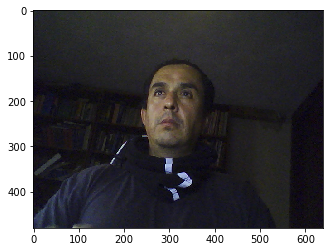

In [74]:
plt.imshow(img)
image=np.copy(img)



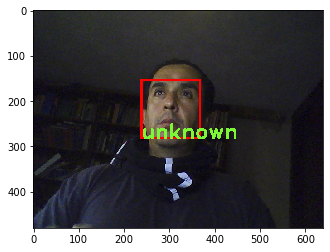

In [75]:
boundRect=np.asarray(res.Angs.data).astype('int')
debug_image= cv2.rectangle(image, (boundRect[1],boundRect[0]), (boundRect[3],boundRect[2]), (255, 0, 0), 4)


debug_image = cv2.putText(
  img = debug_image,
  text = res.Ids.ids,
  org = (boundRect[3],boundRect[2]),
  fontFace = cv2.FONT_HERSHEY_DUPLEX,
  fontScale = 1.5,
  color = (125, 246, 55),
  thickness = 3
)


plt.imshow(debug_image)


In [77]:
#train a new face
#request
def train_face(image, name):
    req=RecognizeFaceRequest()
    strings=Strings()
    string_msg= String()
    string_msg.data=name
    req.Ids.ids.append(string_msg)

    img_msg=bridge.cv2_to_imgmsg(image)
    req.in_.image_msgs.append(img_msg)
    res=train_new_face(req)
    
    return res.Ids.ids[0].data.split(' ')[0] == 'trained'


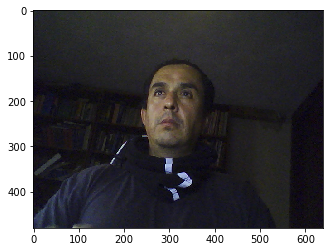

In [83]:

if train_face(img,'Jack'):
    plt.imshow(img)
    


In [84]:
res, img =wait_for_face(60)

Got  image with shape (480, 640, 3)
at least one face found
0 Jack
return res,img Ds: 
  data: 0.6243902444839478
Angs: 
  data: [168.0, 368.0, 297.0, 239.0]
Ids: 
  ids: "Jack"


In [82]:
out

True

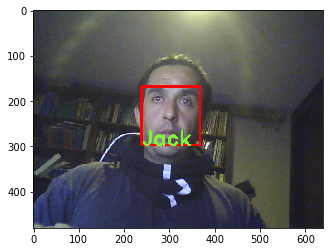

In [86]:
image=np.copy(img)
boundRect=np.asarray(res.Angs.data).astype('int')
debug_image= cv2.rectangle(image, (boundRect[1],boundRect[0]), (boundRect[3],boundRect[2]), (255, 0, 0), 4)


debug_image = cv2.putText(
  img = debug_image,
  text = res.Ids.ids,
  org = (boundRect[3],boundRect[2]),
  fontFace = cv2.FONT_HERSHEY_DUPLEX,
  fontScale = 1.5,
  color = (125, 246, 55),
  thickness = 3
)


plt.imshow(debug_image)
#plt.imshow(cv2_img[34:201,67:67+167])